In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import os 

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure

from scipy.stats import ttest_ind
import json

from tqdm import tqdm

## Load Data 

In [2]:
DATASET_DIRECTORY = 'dataset/MovieSummaries/'


# Load actors df 
character_columns = ['Wikipedia_ID','Freebase_ID', 'release_date', 'movie_name','date_of_birth', 'sex' , 'height',
                     'ethnicity', 'actor_name', 'age_at_realease', 'character2actor_map_ID', 'character_ID', 'actor_ID']
actors_df = pd.read_csv(DATASET_DIRECTORY + 'character.metadata.tsv', sep='\t',  header=None,names=character_columns,skiprows=1)

# Load movies df
movie_columns = ['Wikipedia_ID','Freebase_ID','name','release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres' ]
movies_df = pd.read_csv(DATASET_DIRECTORY + 'movie.metadata.tsv', sep='\t',  header=None,names=movie_columns,skiprows=1)

# Load plots summaries
with open(DATASET_DIRECTORY + 'plot_summaries.txt' ) as f:
    plot_summaries = f.readlines()

## Clean / Process Data

In [3]:
# convert genres to a list of genres for each row
movies_df['genres'] = [ [ v for k, v in  json.loads(dico).items() ] for dico in movies_df.genres.values]

In [4]:
def flatten(l):
    """
    method to flatten a list of lists to just a list 
    """
    return [item for sublist in l for item in sublist]


# compute popularity of each genre and sort them in descending order 
genres = flatten(movies_df['genres'].values)
all_genres = set(genres)
unique, counts = np.unique(genres, return_counts=True)
genres_value_counts = sorted(zip(unique, counts), key=lambda t: t[1], reverse=True)

top_genres, nb_appearances = list(map(list, zip(*genres_value_counts)))

In [5]:
# select the number of top genres to analyse keeping only genres that appear more than
# MIN_NUMBER_OF_APPEARANCES times

MIN_NUMBER_OF_APPEARANCES = 5000
nb_genres = ( np.array(nb_appearances) >= MIN_NUMBER_OF_APPEARANCES ).sum()
selected_genres = set(top_genres[:nb_genres])

# for each movie we create nb_genres new columns who contain 1 , 0 ( True / False) values
# depending if the genre of the column appears in the movie genres field
# these new columns are useful for later sex representations by movie genres
present = np.zeros((movies_df.shape[0], len(selected_genres)))

for idx, row in movies_df.iterrows():

    movie_genres = set(row.genres)
    for genre_idx, genre in enumerate(selected_genres):
        present[idx, genre_idx] = int(genre in movie_genres)

for idx, genre in enumerate(selected_genres):    
        movies_df[genre] = present[:, idx]


In [6]:
# merge movies and actors dataframe to study gender representation in different movie genres
to_drop = ['Wikipedia_ID', 'release_date']
actors_movies_df = actors_df.merge(movies_df.drop(columns=to_drop), how='inner', on='Freebase_ID')

## Initial Analyses

In [32]:
# Interested in the number of movies and number of roles
# as well as the number of features per data point
print(f"movies: ( # movies, # features) : {movies_df.shape}")
print(f"actors: ( # actors, # features) : {actors_df.shape}")

movies: ( # movies, # features) : (81740, 22)
actors: ( # actors, # features) : (450668, 13)


In [33]:
# It's important to check how much data is missing 
print("Number of missing features for movies")
print(movies_df[movie_columns].isna().sum())
print()
print("Number of missing features for actors")
print(actors_df.isna().sum())

Number of missing features for movies
Wikipedia_ID              0
Freebase_ID               0
name                      0
release_date           6902
box_office_revenue    73340
runtime               20450
languages                 0
countries                 0
genres                    0
dtype: int64

Number of missing features for actors
Wikipedia_ID                   0
Freebase_ID                    0
release_date                9995
movie_name                257875
date_of_birth             106145
sex                        45609
height                    295845
ethnicity                 344610
actor_name                  1228
age_at_realease           158113
character2actor_map_ID         0
character_ID              257865
actor_ID                     815
dtype: int64


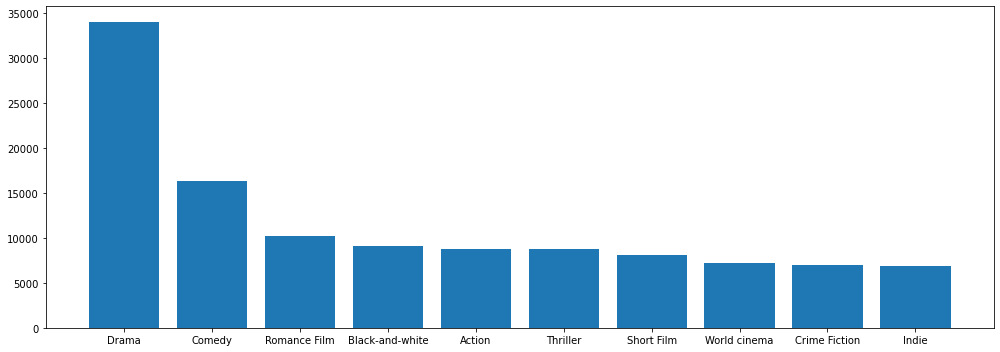

In [11]:



bins = top_genres[:10]
values = nb_appearances[:10]
fig, ax = plt.subplots(figsize = (14,5))
ax.bar(np.arange(len(values)),values)
x = np.arange(len(bins))
ax.set_xticks(x, bins)

plt.tight_layout()
plt.show()

In [12]:
sex_genre_df = actors_movies_df[~ actors_movies_df['sex'].isna()]
sex_genre_df = pd.DataFrame(sex_genre_df[selected_genres].sum(), columns=['all'])
sex_genre_df['women'] = actors_movies_df[actors_movies_df['sex'] == 'F'][selected_genres].sum() / sex_genre_df['all'] * 100
sex_genre_df['men'] = actors_movies_df[actors_movies_df['sex'] == 'M'][selected_genres].sum() / sex_genre_df['all'] * 100
sex_genre_df = sex_genre_df.round()

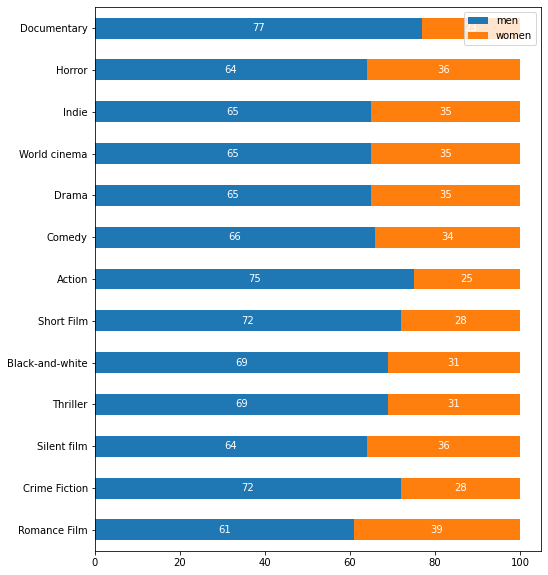

In [13]:
ax = sex_genre_df[['men', 'women']].plot.barh(stacked=True, figsize = (8,10))
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='w')

In [14]:
actors_df.sex.value_counts()

M    270257
F    134802
Name: sex, dtype: int64

In [15]:
res = actors_df.groupby('sex').actor_ID.unique()
res[0].shape[0]

35864

In [16]:
res[1].shape[0]

61519

In [17]:
res[0].shape[0] / res[1].shape[0] 

0.5829743656431347

In [18]:
actors_df.keys()

Index(['Wikipedia_ID', 'Freebase_ID', 'release_date', 'movie_name',
       'date_of_birth', 'sex', 'height', 'ethnicity', 'actor_name',
       'age_at_realease', 'character2actor_map_ID', 'character_ID',
       'actor_ID'],
      dtype='object')

In [19]:
actors_age_df = actors_df[ ~actors_df['age_at_realease'].isna()]
actors_age_df = actors_age_df[ actors_age_df['age_at_realease'] >= 0]
actors_age_df.age_at_realease.sort_values().value_counts().sort_index()

0.0       52
1.0       39
2.0       69
3.0       87
4.0      130
        ... 
95.0      12
96.0       7
97.0       3
99.0       2
103.0      2
Name: age_at_realease, Length: 100, dtype: int64

Text(0, 0.5, 'number of appearances')

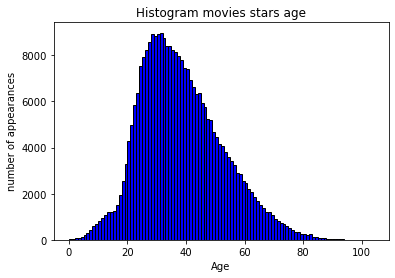

In [20]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns


plt.hist(actors_age_df['age_at_realease'], [x for x in range(105)], color = 'blue', edgecolor = 'black')
# Add labels
plt.title('Histogram movies stars age')
plt.xlabel('Age')
plt.ylabel('number of appearances')

In [21]:
def quartiles(data):
    return [np.quantile(data, x/4) for x in range(1, 4)]
#     return [ np.quantile(data, 0.1), np.quantile(data, 0.5), np.quantile(data, 0.9)]

Women[24.0, 30.0, 40.0]
Men[31.0, 39.0, 49.0]
Actors[28.0, 36.0, 47.0]


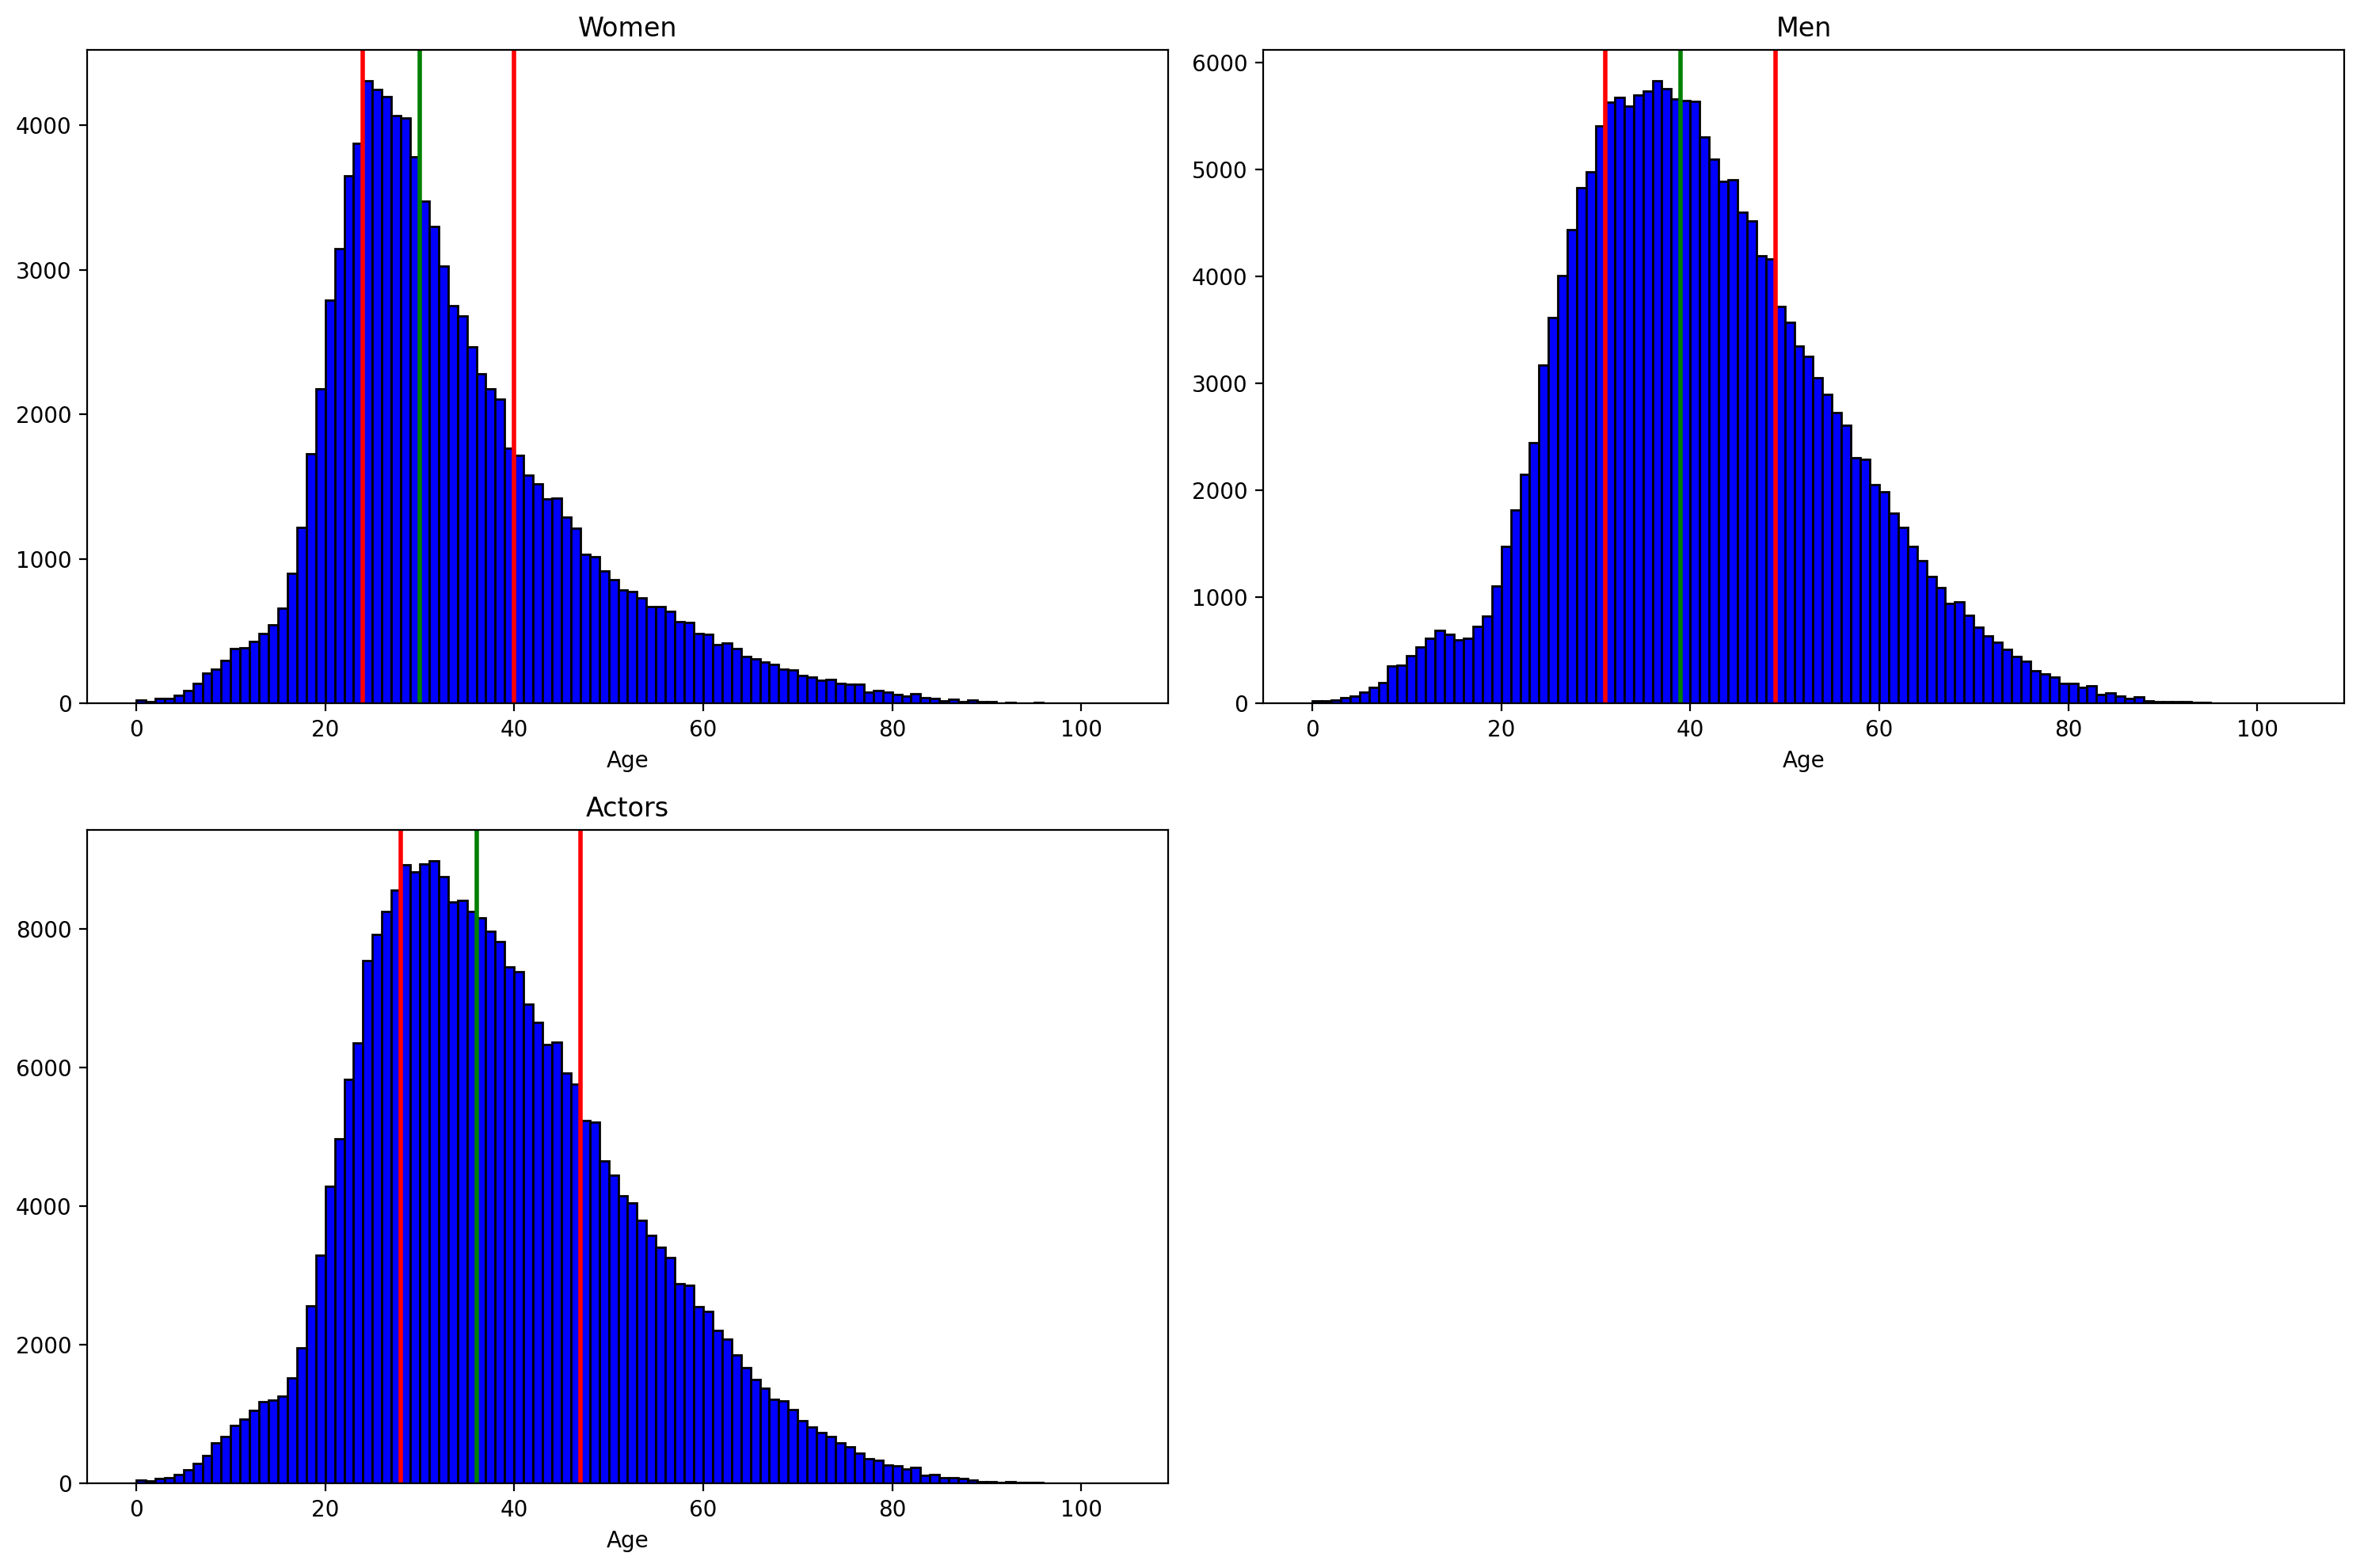

In [22]:

categories = [actors_age_df[actors_age_df['sex'] == "F"]['age_at_realease'],
              actors_age_df[actors_age_df['sex'] == "M"]['age_at_realease'],
              actors_age_df['age_at_realease']]

cat_names = [ "Women", "Men", "Actors"]




figure(figsize=(15, 10), dpi=200)
# Show 4 different binwidths
for i, data in enumerate(categories):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(data, [x for x in range(105)], color = 'blue', edgecolor = 'black')
    stats = quartiles(data)
    print(cat_names[i] + str(stats))
    
    ax.axvline(stats[0], color='r', linewidth=2)
    ax.axvline(stats[1], color='g', linewidth=2)
    ax.axvline(stats[2], color='r', linewidth=2)
    ax.set_xlabel('Age')
    
#     # Title and labels
    ax.set_title(cat_names[i])
# #     ax.set_xlabel('Delay (min)', size = 22)
# #     ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

In [23]:
ttest_ind(categories[1], categories[0])

Ttest_indResult(statistic=140.9261997664695, pvalue=0.0)

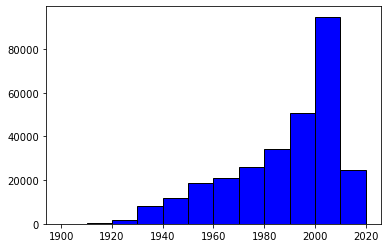

In [24]:
import datetime
years_apparue = actors_age_df.release_date.astype('datetime64[ns]').dt.year

binwidth = 10
start = int(min(years_apparue/10))*10
end  = (int(max(years_apparue/10))+2)*10
plt.hist(years_apparue, bins=range(start, end , binwidth), color = 'blue', edgecolor = 'black')
plt.show()
# actors_age_df.release_date


In [25]:
actors_df.groupby(['actor_name', 'sex'])['actor_ID' ].count().sort_values(ascending=False).head(50)#.value_counts()

actor_name            sex
Mel Blanc             M      791
Mithun Chakraborty    M      328
Oliver Hardy          M      299
Mohanlal              M      234
Moe Howard            M      225
Mammootty             M      225
Dharmendra Deol       M      219
Larry Fine            M      219
Amitabh Bachchan      M      206
Prakash Raj           M      205
Brahmanandam          M      204
Kamal Haasan          M      198
Shakti Kapoor         M      191
Harold Lloyd          M      191
Jagathi Sreekumar     M      191
Anupam Kher           M      191
Frank Welker          M      183
Rajnikanth            M      178
John Wayne            M      178
Nassar                M      172
Nedumudi Venu         M      167
Stan Laurel           M      165
Amrish Puri           M      158
Roscoe Arbuckle       M      158
Paresh Rawal          M      158
Christopher Lee       M      152
Harry Carey           M      149
Gulshan Grover        M      148
Prem Chopra           M      138
Rekha Ganesan    

In [26]:
from scipy import stats
stats.ttest_ind(categories[0], categories[1])

Ttest_indResult(statistic=-140.9261997664695, pvalue=0.0)

In [27]:
data_bins = [[1900+ 10*x, 1910 + 10*x] for x in range(12)]
data_bins

[[1900, 1910],
 [1910, 1920],
 [1920, 1930],
 [1930, 1940],
 [1940, 1950],
 [1950, 1960],
 [1960, 1970],
 [1970, 1980],
 [1980, 1990],
 [1990, 2000],
 [2000, 2010],
 [2010, 2020]]

[1900, 1910] | 
[1910, 1920] | female:[9.0, 14.0, 16.0]  r: 7  | male:[4.0, 6.0, 11.25]  r: 7  | all:[6.0, 13.0, 16.0]  r: 10 | 
[1920, 1930] | female:[19.0, 21.0, 24.0] r: 5  | male:[10.0, 21.0, 25.0] r: 15 | all:[18.0, 21.0, 24.0] r: 6  | 
[1930, 1940] | female:[21.5, 25.0, 28.0] r: 6  | male:[25.0, 30.0, 33.0] r: 8  | all:[23.0, 27.0, 31.0] r: 8  | 
[1940, 1950] | female:[23.0, 27.0, 33.0] r: 10 | male:[29.0, 35.0, 40.0] r: 11 | all:[26.0, 32.0, 38.0] r: 12 | 
[1950, 1960] | female:[24.0, 29.0, 36.0] r: 12 | male:[31.0, 38.0, 45.0] r: 14 | all:[28.0, 35.0, 43.0] r: 15 | 
[1960, 1970] | female:[24.0, 30.0, 39.0] r: 15 | male:[33.0, 40.0, 49.0] r: 16 | all:[29.0, 38.0, 46.0] r: 17 | 
[1970, 1980] | female:[24.0, 31.0, 41.0] r: 17 | male:[32.0, 41.0, 51.0] r: 19 | all:[29.0, 38.0, 49.0] r: 20 | 
[1980, 1990] | female:[23.0, 31.0, 41.0] r: 18 | male:[31.0, 40.0, 51.0] r: 20 | all:[28.0, 37.0, 48.0] r: 20 | 
[1990, 2000] | female:[24.0, 31.0, 42.0] r: 18 | male:[31.0, 40.0, 50.0] r: 19 |

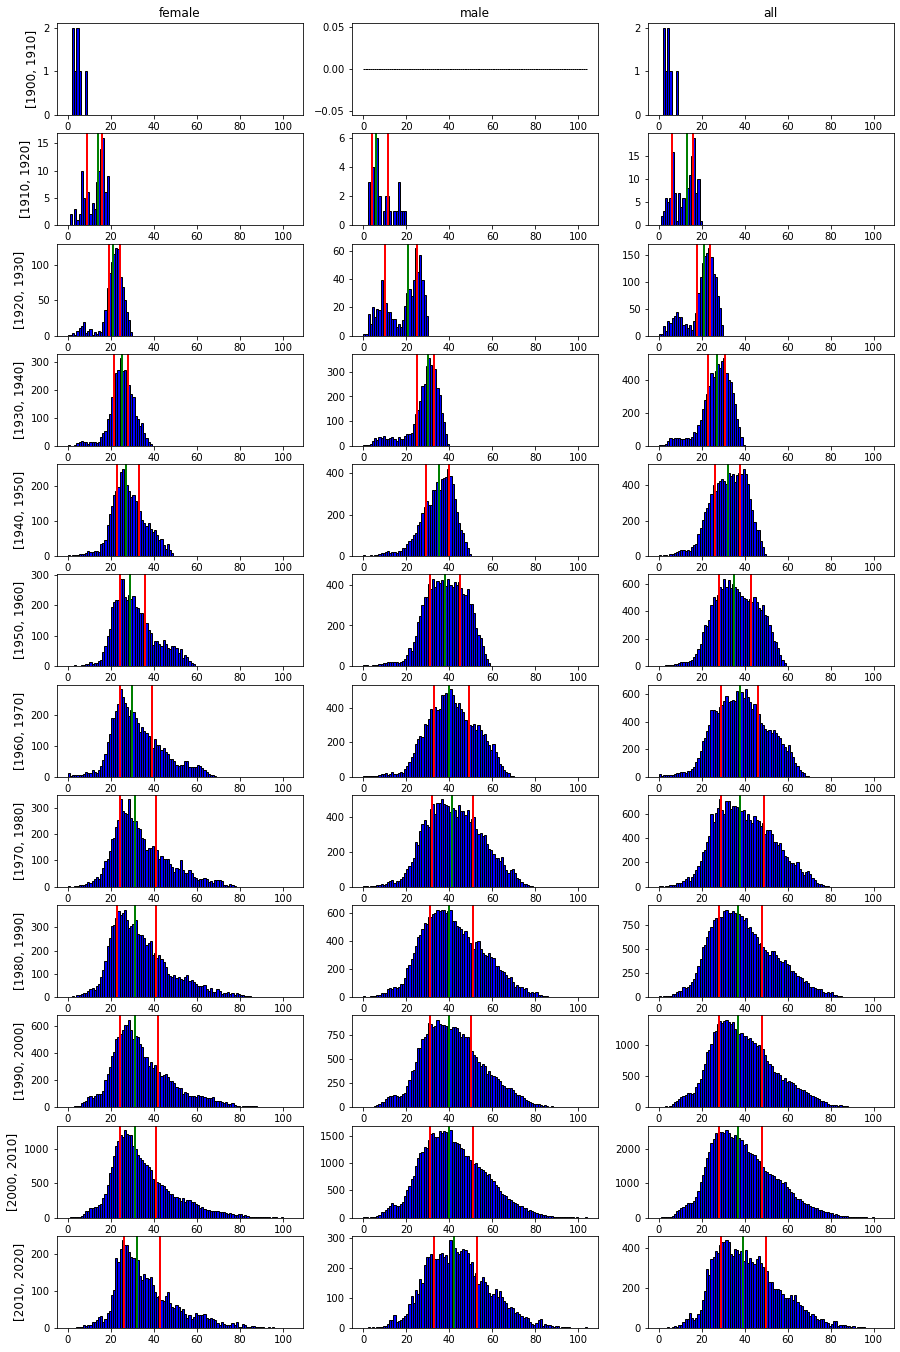

<Figure size 3000x3000 with 0 Axes>

In [28]:

sex_df_dict = {'female': actors_age_df[actors_age_df['sex'] == "F"],
              'male': actors_age_df[actors_age_df['sex'] == "M"],
              'all': actors_age_df}

cat_names = [ "Women", "Men", "Actors"]


fig, axes = plt.subplots(nrows=12, ncols=3, figsize=(15, 24))


figure(figsize=(15, 15), dpi=200)
# Show 4 different binwidths
for row, date_range in enumerate(data_bins):
    print(date_range, end=' | ')
    for column, sex in enumerate(sex_df_dict.keys()):
        

        # Set up the plot
#         ax = plt.subplot(12, 3, row*3 + column + 1)
        
        # Draw the plot
        rel_y = np.array([date.split('-')[0] for date in  sex_df_dict[sex]['release_date']])
        data = sex_df_dict[sex][ (rel_y  > str(date_range[0]) ) & (rel_y  < str(date_range[1]) )]['age_at_realease']
        axes[row,column].hist(data, [x for x in range(105)], color = 'blue', edgecolor = 'black')
        data = data.values
        if( data.shape[0] > 10):
            bstats = quartiles(data)
#             print( f"{sex}:{str(bstats):18} #{data.shape[0]:5} | ", end='' )
            print( f"{sex}:{str(bstats):18} r: {str(int(bstats[2] - bstats[0])):2} | ", end='' )

            axes[row,column].axvline(bstats[0], color='r', linewidth=2)
            axes[row,column].axvline(bstats[1], color='g', linewidth=2)
            axes[row,column].axvline(bstats[2], color='r', linewidth=2)

#     #     # Title and labels
#         ax.set_title(cat_names[i])
    # #     ax.set_xlabel('Delay (min)', size = 22)
    # #     ax.set_ylabel('Flights', size= 22)
    print()
    
for ax, col in zip(axes[0], sex_df_dict.keys()):
    ax.set_title(col)

for ax, row in zip(axes[:,0], data_bins):
    ax.set_ylabel(row, size='large' )
    
# plt.tight_layout()
plt.show()

In [29]:
len('[19.0, 21.0, 24.0]')

18

In [30]:
rel_y = np.array([date.split('-')[0] for date in  sex_df_dict['female']['release_date']])
sex_df_dict['female'][ (rel_y  > str(data_bins[0][0]) ) & (rel_y  < str(data_bins[0][1]) )]['age_at_realease']
#[( sex_df_dict['f']['release_date'])]#.dt.Year < str(data_bins[0][0]))]  #['age_at_realease']

26341     4.0
132702    8.0
192731    3.0
280212    4.0
397150    2.0
397151    5.0
447462    2.0
Name: age_at_realease, dtype: float64

In [31]:
ages = np.zeros((len(data_bins), 3))
for row, date_range in enumerate(data_bins):
    for column, sex in enumerate(sex_df_dict.keys()):
        
        rel_y = np.array([date.split('-')[0] for date in  sex_df_dict[sex]['release_date']])
        data = sex_df_dict[sex][ (rel_y  > str(date_range[0]) ) & (rel_y  < str(date_range[1]) )]['age_at_realease']
        
        ages[row,column] = data.shape[0]

    
for row, date_range in enumerate(data_bins):
    print(date_range, end=' | ')
    for column, sex in enumerate(sex_df_dict.keys()):
        print( f"{sex}:{data.shape[0]:6} ratio: {round(ages[row,column] / ages[row,2],2):4.2f} | ", end='' )
    print()

[1900, 1910] | female: 14677 ratio: 1.00 | male: 14677 ratio: 0.00 | all: 14677 ratio: 1.00 | 
[1910, 1920] | female: 14677 ratio: 0.74 | male: 14677 ratio: 0.26 | all: 14677 ratio: 1.00 | 
[1920, 1930] | female: 14677 ratio: 0.60 | male: 14677 ratio: 0.39 | all: 14677 ratio: 1.00 | 
[1930, 1940] | female: 14677 ratio: 0.47 | male: 14677 ratio: 0.53 | all: 14677 ratio: 1.00 | 
[1940, 1950] | female: 14677 ratio: 0.36 | male: 14677 ratio: 0.64 | all: 14677 ratio: 1.00 | 
[1950, 1960] | female: 14677 ratio: 0.32 | male: 14677 ratio: 0.68 | all: 14677 ratio: 1.00 | 
[1960, 1970] | female: 14677 ratio: 0.29 | male: 14677 ratio: 0.70 | all: 14677 ratio: 1.00 | 
[1970, 1980] | female: 14677 ratio: 0.30 | male: 14677 ratio: 0.69 | all: 14677 ratio: 1.00 | 
[1980, 1990] | female: 14677 ratio: 0.31 | male: 14677 ratio: 0.68 | all: 14677 ratio: 1.00 | 
[1990, 2000] | female: 14677 ratio: 0.33 | male: 14677 ratio: 0.66 | all: 14677 ratio: 1.00 | 
[2000, 2010] | female: 14677 ratio: 0.35 | male: 1